# Imports

In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import os
import matplotlib.pyplot as plt
import folium
from zipfile import ZipFile
import seaborn as sns
import numpy as np
import datetime as dt
from collections import Counter

# Data

## Public

In [2]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

# AMWA
amwa_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/Kml Ruta AMVA'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        amwa_bus_routes = gpd.GeoDataFrame(pd.concat([amwa_bus_routes, df], ignore_index=True))
amwa_bus_routes.reset_index(inplace=True)
amwa_bus_routes['carrier'] = 'AMWA'

# SMM
smm_bus_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/bus_routes/medellin_bus_routes/kml Ruta SMM'):
    for file in files:
        path = os.path.join(root, file)
        df = gpd.read_file(path, driver='KML')
        smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        
smm_bus_routes.reset_index(inplace=True)
smm_bus_routes['carrier'] = 'SMM'

# METRO
metro_routes = gpd.GeoDataFrame()
for root, dirs, files in os.walk('raw_data/medellin_metro/medellin_metro_stations'):
    for file in files:
        path = os.path.join(root, file)
        kmz = ZipFile(path, 'r')
        kml = kmz.open('doc.kml', 'r')
        df = gpd.read_file(kml, driver='KML')
        metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
metro_routes.reset_index(inplace=True)

all_dfs = [metro_routes, smm_bus_routes, amwa_bus_routes]
all_routes = gpd.GeoDataFrame(pd.concat(all_dfs, ignore_index=True))

# TEST
all_routes['carrier'].value_counts()

SMM     11297
AMWA      270
Name: carrier, dtype: int64

## Bike stations

In [3]:
bike_df_all = pd.read_csv('raw_data/bike_loans.csv', sep=';').drop(columns=['Importe', 
                                                                        'DescripcionImporte', 
                                                                        'operario'])
bike_df_all['Fecha_Prestamo'] = bike_df_all['Fecha_Prestamo'].astype('datetime64[ns]')
bike_df_all['Fecha_Devolucion'] = bike_df_all['Fecha_Devolucion'].astype('datetime64[ns]')

bike_df_all.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Num_Bici_Hist                     float64
dtype: object

In [4]:
bike_df_all = bike_df_all.dropna()

## Pre covid cut

In [35]:
bike_df_all['covid'] = bike_df_all.Fecha_Devolucion > '31-12-2019'

In [6]:
bike_df = bike_df_all[bike_df_all.Fecha_Devolucion <= '31/12/2019']

In [7]:
bike_df.shape

(10737486, 11)

# Cut df

In [8]:
# filter pre covid
bike_df['Fecha_Devolucion'].max()

Timestamp('2019-12-30 22:43:20')

In [9]:
bike_df.sample(20)

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,covid
95295,5090475,36768,000017AFD5E3,2016-11-16 07:17:43,2016-11-16 07:35:59,32,1,13.0,1.0,525.0,True
2540635,1390333,31266,000017B04F5A,2016-01-05 17:20:49,2016-01-05 17:32:51,20,1,38.0,1.0,1241.0,True
8383496,10928745,40399,00E73C222B5E,2019-02-19 07:27:38,2019-02-19 07:46:36,37,1,12.0,1.0,1234.0,True
4173304,5019629,47403,0000164BA708,2016-11-03 09:14:48,2016-11-03 09:27:18,1,1,55.0,4.0,1000.0,True
2197499,1145569,24446,000017B020FD,2015-11-03 18:50:57,2015-11-03 19:07:58,11,1,2.0,1.0,520.0,True
9311346,11878351,97064,009A9A222B5E,2019-05-20 16:15:41,2019-05-20 16:27:57,3,1,1.0,1.0,940.0,True
2435245,1315489,4688,0000164C25B9,2015-12-09 11:42:26,2015-12-09 11:47:40,5,1,62.0,10.0,1449.0,True
2873465,1635379,30935,000017AFEF2C,2016-02-22 14:15:01,2016-02-22 15:09:59,57,1,66.0,1.0,1007.0,True
2066824,6554117,29446,000017AFC891,2017-06-30 18:41:00,2017-06-30 18:50:01,8,1,11.0,3.0,601.0,True
7781831,10337961,114991,00CE67222B5E,2018-12-03 18:10:10,2018-12-03 18:10:50,22,14,22.0,14.0,883.0,True


In [10]:
# Id_Historico_Prestamo = almost unique => remove duplicates

In [11]:
print(f'In total we have {len(bike_df.Id_Tag_Bicicleta.unique())} unique bikes over all recorded time')

In total we have 4491 unique bikes over all recorded time


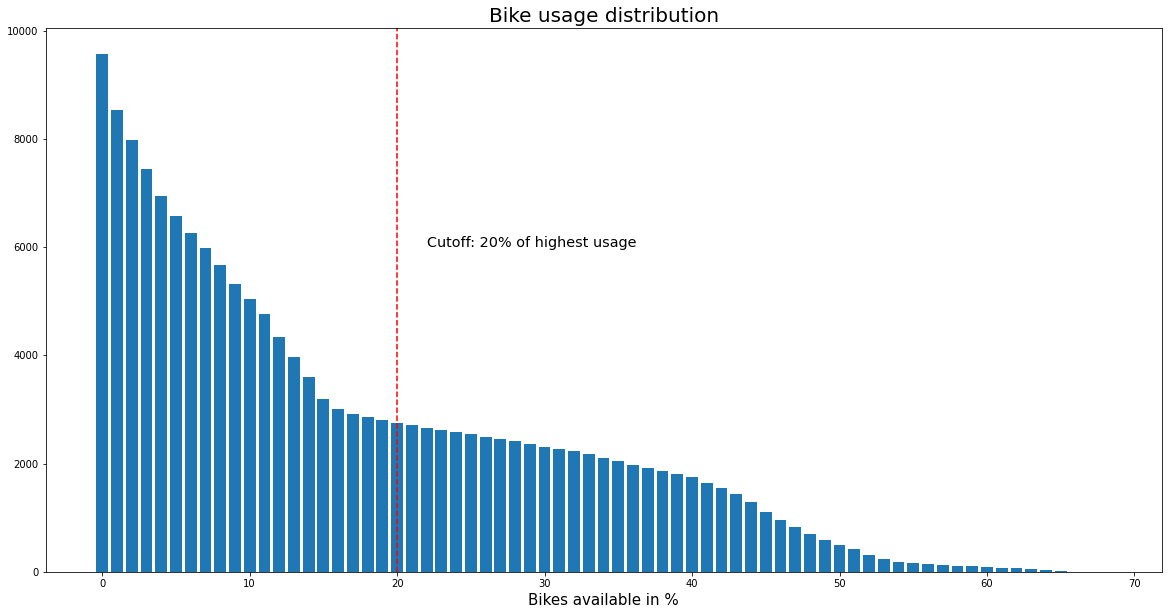

In [12]:
# how is the usage of each bike distributed
# .hist() doesn't work
plt.figure(figsize=(20,10))
plt.title('Bike usage distribution', size=20)
counts = bike_df.Id_Tag_Bicicleta.value_counts()[::66]
y_pos = np.arange(len(counts))
plt.bar(y_pos, counts)
plt.xlabel('Bikes available in %', size=15)
plt.text(x=22, y=6000, s=f'Cutoff: 20% of highest usage', size='x-large')
plt.axvline(20, color='r', linestyle='--')

plt.show()

**Note**<br>
There is a strong elbow visible between the 10th and 20th percentile. Analyzing both parts and their locations might give insight on the efficiency of bike distribution. 

# Most used routes

In [13]:
bike_df['hour'] = bike_df.Fecha_Prestamo.dt.hour

<ipython-input-13-067332580d8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['hour'] = bike_df.Fecha_Prestamo.dt.hour


In [14]:
bike_df['routes'] = bike_df.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)
                                  

<ipython-input-14-5e2bf3e2c132>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['routes'] = bike_df.apply(lambda x: f'{x.Id_Aparcamiento_Origen}_{int(x.Id_Aparcamiento_Destino)}', axis=1)


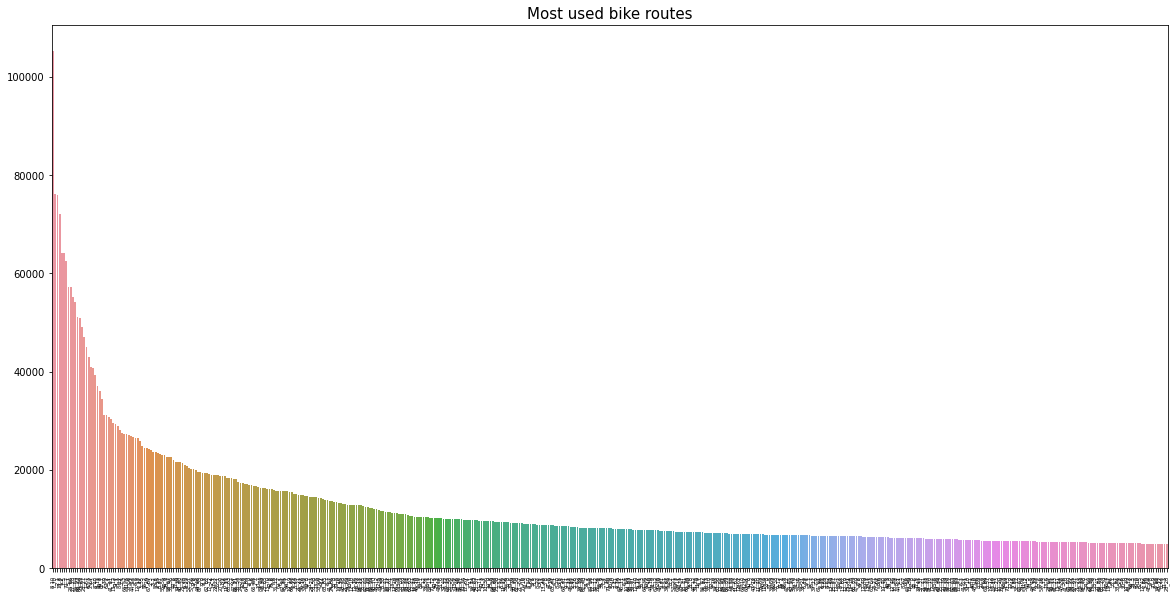

In [15]:
counts = bike_df.routes.value_counts()[:500]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.title('Most used bike routes', size=15)
plt.xticks(rotation=90, size=5)
plt.show()

# rental distribution

In [16]:
bike_df_all['hour'] = bike_df_all.Fecha_Prestamo.dt.hour

In [17]:
# grouping by hour
agg = {'Id_Aparcamiento_Origen':'count', 
      'routes': lambda x: list(x)}
routes_by_hr = bike_df.groupby('hour').agg(agg).rename(columns={'Id_Aparcamiento_Origen':'count_rentals'})

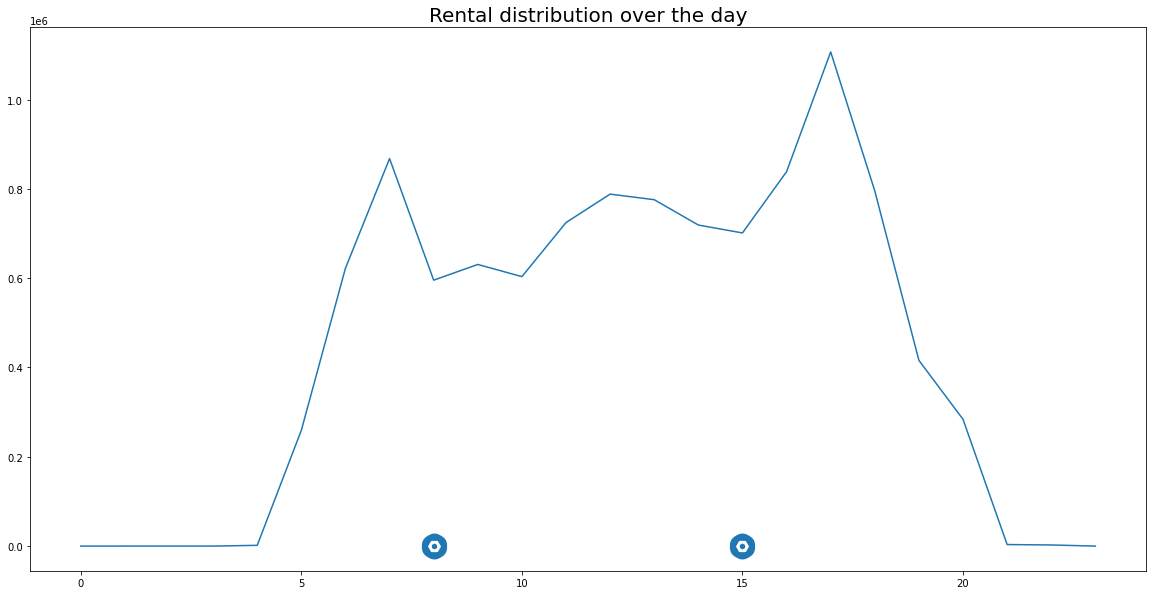

In [18]:
plt.figure(figsize=(20,10))
plt.plot(routes_by_hr.count_rentals)
plt.title('Rental distribution over the day', size=20)
plt.scatter([8,15], [1,1], marker='h', linewidths=20)

## Routes

In [19]:
# count the amount of occuring routes per hour (counting the ocurrences in the lists)
routes_dict = {}
for c, row in routes_by_hr.iterrows():
    routes_dict[c] = dict(Counter(row.routes))

routes_usage = pd.DataFrame.from_dict(routes_dict)

In [44]:
routes_usage['start_id'] = routes_usage.index.map(lambda x: x.split('_')[0])
routes_usage['finish_id'] = routes_usage.index.map(lambda x: x.split('_')[1])
routes_usage['no_move'] = routes_usage.start_id == routes_usage.finish_id

In [63]:
bike_df['timespan_min'] = (bike_df.Fecha_Devolucion - bike_df.Fecha_Prestamo).dt.seconds/60

<ipython-input-63-d8eff50efbbb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_df['timespan_min'] = (bike_df.Fecha_Devolucion - bike_df.Fecha_Prestamo).dt.seconds/60


/Users/moritzgeiger/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


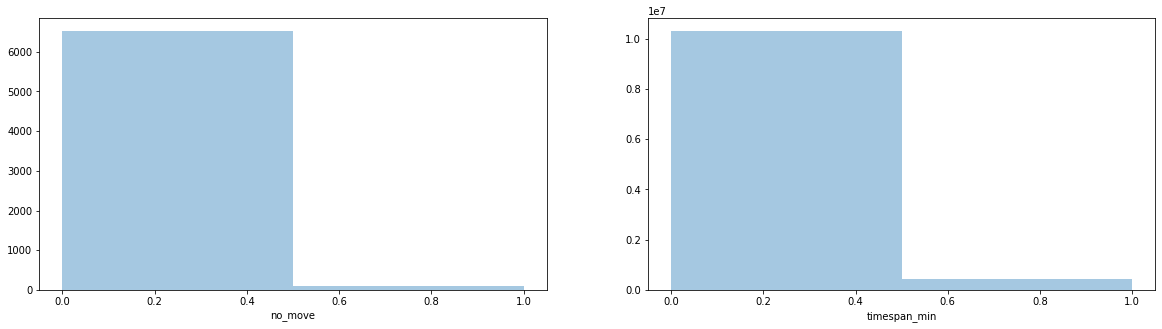

In [76]:
# how many times were bikes returned to the same station
# how many times were bikes rented less than 2 mins
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
sns.distplot(routes_usage.no_move, bins=2, kde=False)
plt.subplot(1,2,2)
under_2 = bike_df.timespan_min < 2
sns.distplot(under_2, bins=2, kde=False)
plt.show()

In [20]:
# take the top5 routes per hour
rank_routes = {}
for hour in routes_usage.columns:
    top3 = dict(routes_usage[hour].sort_values(ascending=False)[:3])
    rank_routes[hour] = top3
rank_routes_df = pd.DataFrame(rank_routes).T

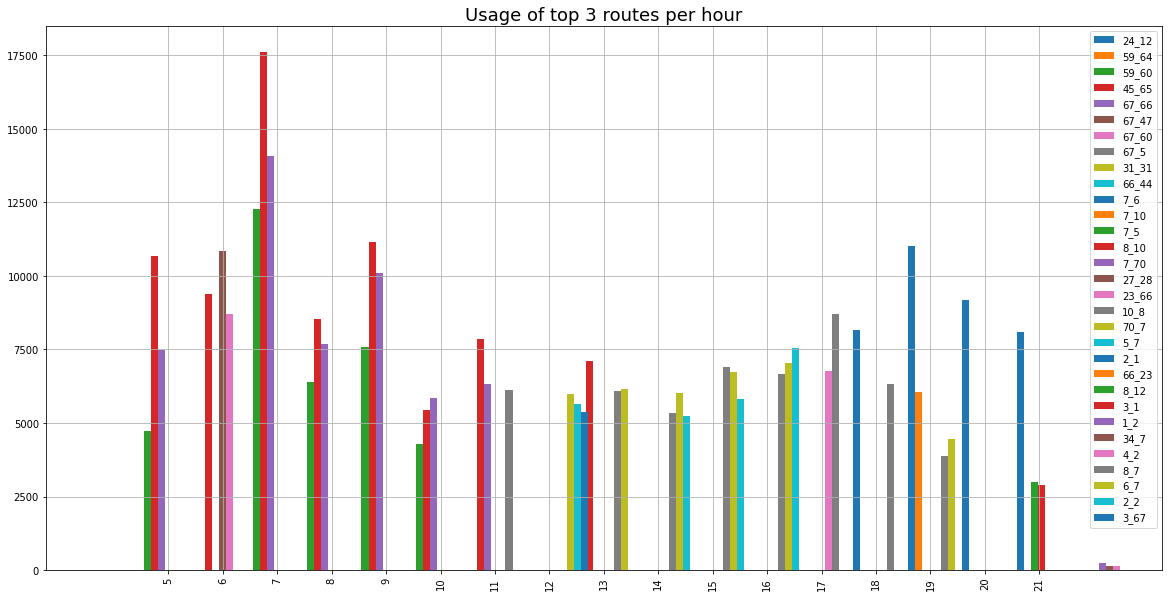

In [21]:
# counts from 0 to 4 in the morning are too low
rank_routes_df.loc[5:21].plot(kind='bar', figsize=(20,10), width=4, stacked=False, align='center')
plt.title('Usage of top 3 routes per hour', size=18)
plt.grid()
plt.show()

**Note**<br>
- In the morning hours the route ```8_10``` is represented in high numbers followed by ```7_70```
- In the evening hours there are more ```2_1``` and ```10_8``` rentals recorded
- Noons and afternoons have a stable distribution of ```70_7``` (returns of the mornings)
- Way less people go back the same way they came from (```8_10``` vs. ```10_8```)

In [22]:
rank_routes

{0: {'24_12': 1.0, '59_64': nan, '59_60': nan},
 1: {'59_64': 3.0, '59_60': 1.0, '45_65': 1.0},
 2: {'67_66': 1.0, '67_47': 1.0, '67_60': 1.0},
 3: {'67_5': 1.0, '31_31': 1.0, '66_44': 1.0},
 4: {'7_6': 121.0, '7_10': 97.0, '7_5': 94.0},
 5: {'8_10': 10661.0, '7_70': 7497.0, '7_5': 4712.0},
 6: {'27_28': 10853.0, '8_10': 9385.0, '23_66': 8706.0},
 7: {'8_10': 17602.0, '7_70': 14072.0, '7_5': 12289.0},
 8: {'8_10': 8541.0, '7_70': 7677.0, '7_5': 6381.0},
 9: {'8_10': 11157.0, '7_70': 10083.0, '7_5': 7571.0},
 10: {'7_70': 5849.0, '8_10': 5455.0, '7_5': 4293.0},
 11: {'8_10': 7866.0, '7_70': 6323.0, '10_8': 6107.0},
 12: {'70_7': 5973.0, '5_7': 5662.0, '2_1': 5360.0},
 13: {'8_10': 7113.0, '70_7': 6170.0, '10_8': 6078.0},
 14: {'70_7': 6015.0, '10_8': 5356.0, '5_7': 5243.0},
 15: {'10_8': 6895.0, '70_7': 6738.0, '5_7': 5818.0},
 16: {'5_7': 7534.0, '70_7': 7028.0, '10_8': 6681.0},
 17: {'10_8': 8721.0, '2_1': 8145.0, '23_66': 6759.0},
 18: {'2_1': 11005.0, '10_8': 6330.0, '66_23': 6053.0

In [33]:
# add a map with circle markers and polylines and weigh them by usage with ipywidgets interact per hour. 
## as soon as we have the coordinates

## Pandemic analysis

In [24]:
bike_df_all['month'] = bike_df.Fecha_Prestamo.dt.month

<AxesSubplot:xlabel='month'>

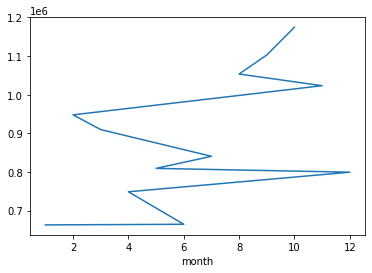

In [28]:
# bike_df_all.groupby('month').count()['Fecha_Prestamo'].T.sort_values().plot()

## most used bike

In [30]:
# extract the most used bike for faster computation
most_used = bike_df_all.Id_Tag_Bicicleta.value_counts().keys()[0]
most_used_df = bike_df_all[bike_df_all.Id_Tag_Bicicleta == most_used]
most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')

<ipython-input-30-d5a6e96cc395>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_used_df['day'] = most_used_df['Fecha_Prestamo'].dt.strftime('%Y/%m/%d')


In [31]:
# assign routes as tuples
most_used_df = most_used_df.dropna()
most_used_df['routes'] = most_used_df.apply(lambda x: (x.Id_Aparcamiento_Origen, int(x.Id_Aparcamiento_Destino)), axis=1)

In [37]:
most_used_df

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Num_Bici_Hist,covid,hour,month,day,routes
51,6501530,91768,000017B04C83,2017-06-21 14:29:56,2017-06-21 14:48:35,67,1,13.0,1.0,1226.0,True,14,6.0,2017/06/21,"(67, 13)"
518,6501842,34657,000017B04C83,2017-06-21 15:02:25,2017-06-21 15:33:56,13,1,1.0,1.0,1226.0,True,15,6.0,2017/06/21,"(13, 1)"
2142,5052934,33384,000017B04C83,2016-11-09 12:02:32,2016-11-09 13:04:42,63,7,63.0,33.0,1226.0,True,12,11.0,2016/11/09,"(63, 63)"
4127,6423636,98219,000017B04C83,2017-06-08 19:44:04,2017-06-08 19:49:20,2,1,55.0,5.0,1226.0,True,19,6.0,2017/06/08,"(2, 55)"
4342,6423556,46550,000017B04C83,2017-06-08 19:11:23,2017-06-08 19:21:52,4,1,2.0,1.0,1226.0,True,19,6.0,2017/06/08,"(4, 2)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7767548,10301237,101322,000017B04C83,2018-11-22 16:43:28,2018-11-22 16:55:52,2,1,3.0,7.0,1226.0,True,16,11.0,2018/11/22,"(2, 3)"
7772631,10304794,38604,000017B04C83,2018-11-23 07:33:21,2018-11-23 07:38:26,3,1,4.0,1.0,1226.0,True,7,11.0,2018/11/23,"(3, 4)"
7772649,10304868,118438,000017B04C83,2018-11-23 07:38:41,2018-11-23 08:01:32,4,1,56.0,27.0,1226.0,True,7,11.0,2018/11/23,"(4, 56)"
7772688,10305247,117040,000017B04C83,2018-11-23 08:05:01,2018-11-23 08:11:11,56,27,64.0,15.0,1226.0,True,8,11.0,2018/11/23,"(56, 64)"


In [32]:
day_df[day_df == day_df.max()].index[0]

NameError: name 'day_df' is not defined

In [38]:
most_used_df.routes.value_counts()

(22, 22)    108
(8, 10)      87
(7, 5)       77
(45, 45)     73
(10, 8)      65
           ... 
(66, 60)      1
(59, 55)      1
(89, 56)      1
(45, 60)      1
(49, 44)      1
Name: routes, Length: 2171, dtype: int64

Busiest day 2016/03/31 with 66 rentals for ID 000017B04C83


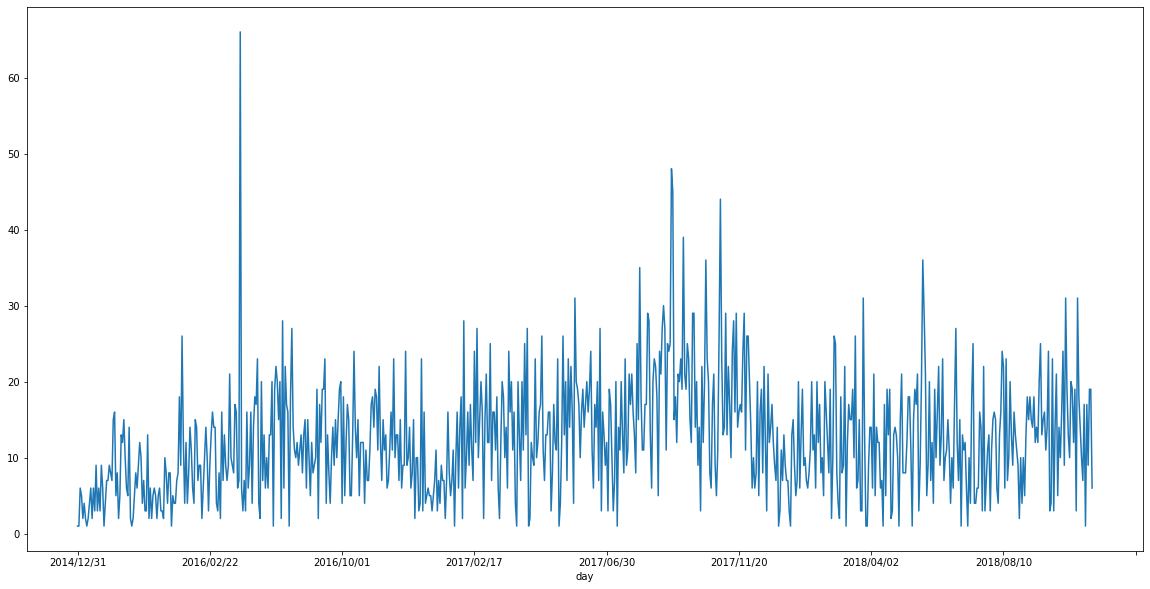

In [39]:
# follow the most used bike by day
day_df = most_used_df.groupby('day').count().sort_index()['Id_Usuario']
day_df.plot(figsize=(20,10))
print(f'Busiest day {day_df[day_df == day_df.max()].index[0]} with {day_df.max()} rentals for ID {most_used}')

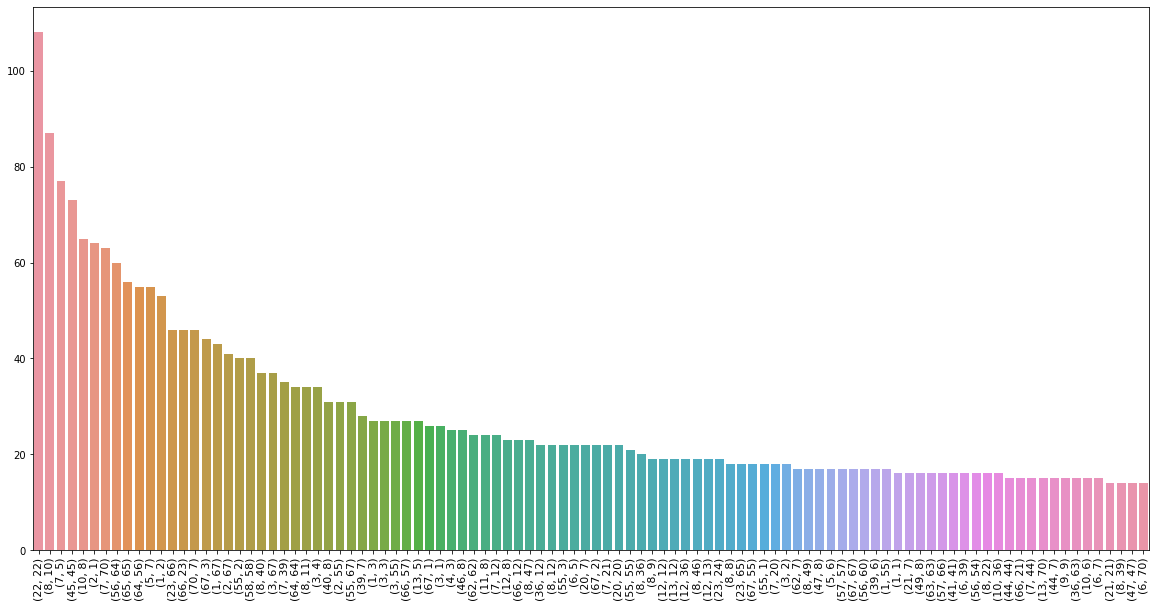

In [40]:
# by route
counts = most_used_df.routes.value_counts()[:100]
x = counts.keys()
y = list(counts)
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90, size=11)
plt.show()